# Previsão de Séries Temporais por Modelo de Auto-regressão

<div style="text-align:justify">
Auto-regressão é um modelo de séries temporal que usa como entrada as observações de etapas anteriores para prever o valor na próxima etapa de tempo. É uma ideia muito simples e pode resultar em previsões precisas em vários problemas de séries temporais.
</div>
<br>
Neste notebook vamos implementar um modelo autoregressivo para previsão de séries temporais com o Python.

### Carregando Pacotes

In [39]:
from pandas import Series
from pandas import concat
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot, lag_plot

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from matplotlib import pyplot
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 15, 6

<div style="text-align:justify">
Como em uma regressão linear, o modelo de auto-regressão modela um valor de saída com base em uma combinação linear dos valores de entrada, como _yhat = b0 + b1*X1_; onde `b0` e `b1` são coeficientes encontrados pela otimização do modelo, e `X` é um valor de entrada.
<br>
<br>
Essa técnica pode ser usada em séries temporais nas quais variáveis de entrada são tomadas como observações em etapas de tempo anteriores, chamadas de variáveis de atraso. Podemos predizer o valor para o próximo passo de tempo (t + 1) dadas as observações nos últimos dois tempos (t-1 e t-2), por exemplo. Como um modelo de regressão, isso seria _X(t+1) = b0 + b1*X(t-1) + b2*X(t-2)_.
</div>

### Dataset de Exemplo
<br>
<div style="text-align:justify">
O datset utilizado neste exemplo descreve as temperaturas mínimas diárias ao longo de 10 anos (1981-1990) na cidade de Melbourne, na Austrália. As unidades estão em graus Celsius e existem 3.650 observações. A fonte dos dados é creditada como o Australian Bureau of Meteorology.
<br><br>
<b>Nota</b>: O arquivo baixado contém alguns caracteres de ponto de interrogação (“?”), que devem ser removidos antes que você possa usar os dados. Abra o arquivo em um editor de texto e remova os caracteres “?”. Também remova qualquer informação de rodapé no arquivo.
</div>

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Value, dtype: float64


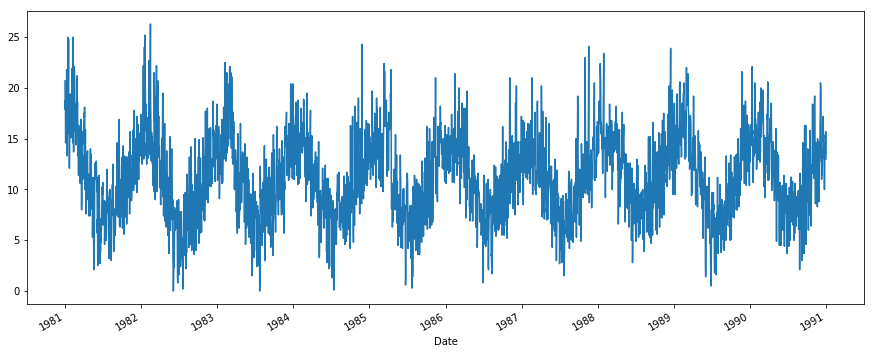

In [40]:
series = Series.from_csv('daily-minimum-temperatures.csv', header=0)
print(series.head())
series.plot()
pyplot.show()

<div style="text-align:justify">
Dado que um modelo de autorregressão supõe que as observações em etapas de tempo anteriores são úteis para prever o valor na próxima etapa de tempo, essa relação entre variáveis é chamada de correlação. Se ambas as variáveis mudarem na mesma direção (por exemplo, subir juntas ou descer juntas), isso é chamado de correlação positiva. Se as variáveis se moverem em direções opostas à medida que os valores mudam (por exemplo, uma sobe e uma desce), então isso é chamado de correlação negativa.
<br><br>
Podemos usar medidas estatísticas para calcular a correlação entre a variável de saída e os valores em etapas de tempo anteriores em vários desfasamentos diferentes. Quanto mais forte a correlação entre a variável de saída e uma variável defasada específica, mais peso o modelo de auto-regressão pode colocar nessa variável.
</div>
<br>
Pontos:
- A correlação é calculada entre a variável e ela mesma nas etapas de tempo anteriores, por isso o nome autocorrelação.

- Calcular a correlação também podem ajudar escolher as variáveis de atraso serão úteis em um modelo e quais não serão.

- Se as variáveis de atraso mostrarem baixa ou nenhuma correlação com a variável de saída, a série temporal pode não ser previsível.

### Análise de Autocorrelação

<div style="text-align:justify">
A seguir, uma verificação visual rápida para verificar se há uma autocorrelação em nosso conjunto de dados de séries temporais. Podemos plotar a observação no passo de tempo anterior (t-1) com a observação no próximo passo de tempo (t + 1) como um gráfico de dispersão.
<br><br>
Isso pode ser feito manualmente criando primeiro uma versão de atraso do conjunto de dados de série temporal e usando uma função de gráfico de dispersão integrada na biblioteca Pandas.
</div>

<div style="text-align:justify">
A seguir, uma verificação visual rápida para verificar se há uma autocorrelação em nosso conjunto de dados de séries temporais. Podemos plotar a observação no passo de tempo anterior `(t - 1)` com a observação no próximo passo de tempo `(t + 1)` como um gráfico de dispersão.
<br><br>
Isso pode ser feito manualmente criando primeiro uma versão de atraso do conjunto de dados de série temporal e usando uma função de gráfico de dispersão integrada na biblioteca Pandas.
</div>

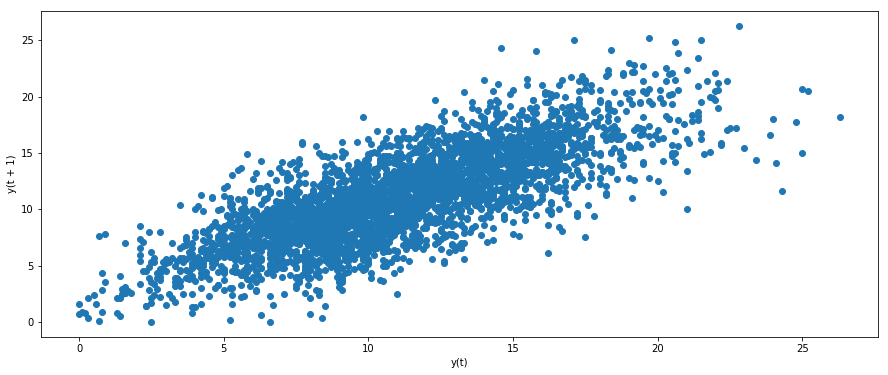

In [41]:
lag_plot(series)
pyplot.show()

<div style="text-align:justify">
Podemos ver um grande grupo de observações ao longo de uma linha diagonal, mostrando claramente uma relação ou alguma correlação. Esse processo pode ser repetido para qualquer outra observação com atraso, como se quiséssemos revisar o relacionamento com os últimos sete dias ou com o mesmo dia do mês passado ou do ano passado.
<br><br>
Outra verificação rápida que podemos fazer é calcular diretamente a correlação entre a observação e a variável lag. Podemos usar um teste estatístico como o coeficiente de correlação de Pearson. Isso produz um número para resumir como duas variáveis correlacionadas estão entre -1 (negativamente correlacionadas) e +1 (correlacionadas positivamente) com valores pequenos próximos a zero indicando baixa correlação e altos valores acima de 0,5 ou abaixo de -0,5 mostrando alta correlação.
</div>

In [42]:
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't']
result = dataframe.corr()
print(result)

         t-1        t
t-1  1.00000  0.77487
t    0.77487  1.00000


<div style="text-align:justify">
Essa abordagem é boa para análises pontuais, porém muito trabalhosa se quisermos verificar um grande número de variáveis de atraso em nossa série temporal. A seguir, veremos uma versão ampliada dessa abordagem.
</div>

### Plot de Autocorrelação

<div style="text-align:justify">
Podemos traçar o coeficiente de correlação para cada variável de latência. Isso pode rapidamente dar uma idéia de quais variáveis de atraso podem ser boas candidatas para uso no modelo preditivo e como a relação entre a observação e seus valores históricos muda com o tempo.
<br><br>
Poderíamos calcular manualmente os valores de correlação para cada variável de atraso e plotar o resultado. Felizmente, o Pandas fornece uma plotagem embutida chamada de função autocorrelation_plot().
<br><br>
O gráfico fornece o número de atraso ao longo do eixo _X_ e o valor do coeficiente de correlação entre -1 e 1 no eixo _Y_. O gráfico também inclui linhas sólidas e tracejadas que indicam o intervalo de confiança de 95% e 99% para os valores de correlação. Os valores de correlação acima dessas linhas são mais significativos do que aqueles abaixo da linha, fornecendo um limite ou corte para selecionar valores de lag mais relevantes.
</div>

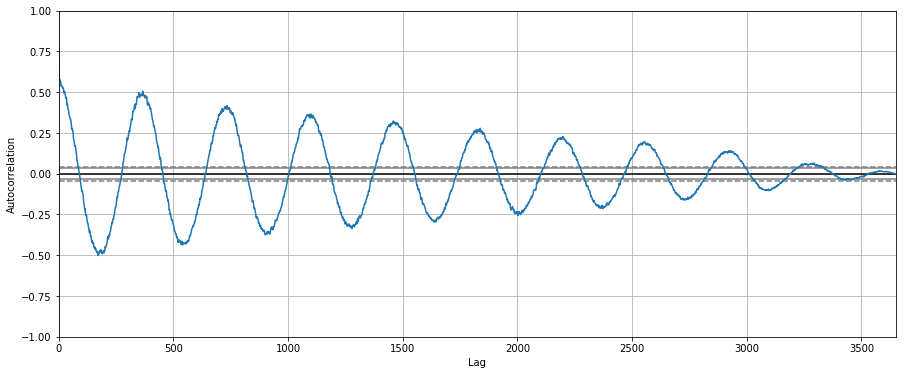

In [43]:
autocorrelation_plot(series)
pyplot.show()

<div style="text-align:justify">
Executando o exemplo mostra o balanço em correlação positiva e negativa como os valores de temperatura. Os valores de temperatura mudam entre as estações de verão e inverno em cada ano anterior.
</div>

Neste exemplo, limitamos as variáveis de atraso para melhorar a legibilidade.

### Auto-correlação

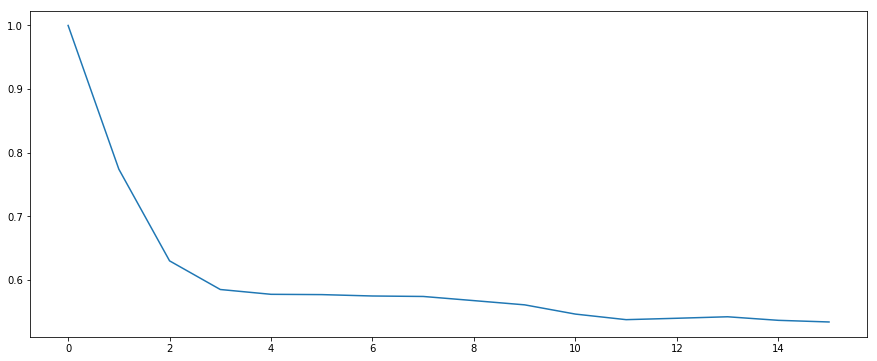

In [44]:
acf_plot = acf(series, nlags=15)
plt.plot(acf_plot)
plt.show()

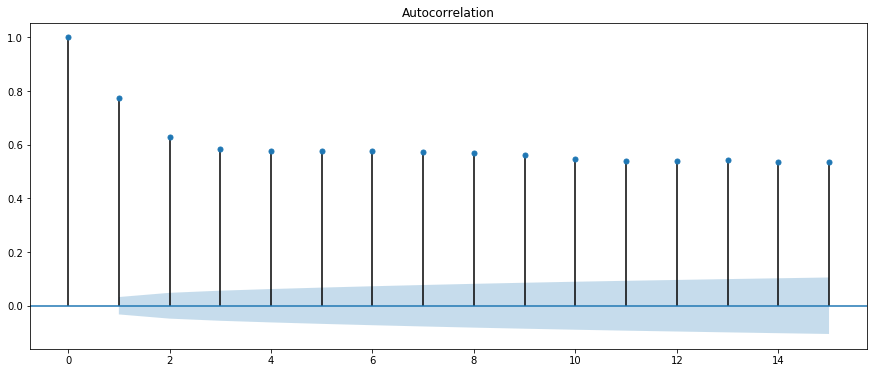

In [45]:
plot_acf(series, lags=15)
pyplot.show()

### Auto-correlação Parcial

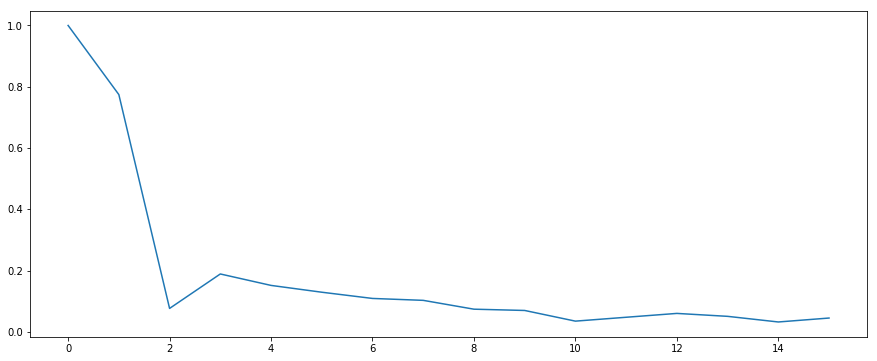

In [46]:
pacf_plot = pacf(series, nlags=15)
plt.plot(pacf_plot)
plt.show()

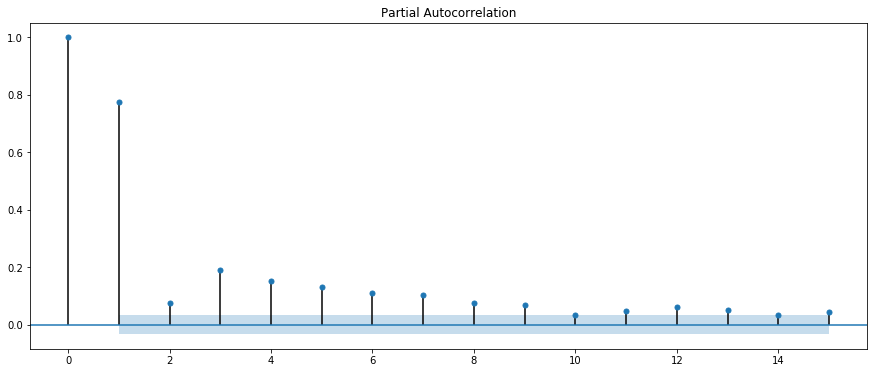

In [47]:
plot_pacf(series, lags=15)
pyplot.show()

### Baseline

<div style="text-align:justify">
Nesse momento já passamos por algumas técnicas de análise da série temporal, vamos agora estabelecer um baseline do nosso modelo de autocorrelação para que em seguida possamos tratar de variações desse modelo.
<br><br>
Vamos supor que queremos desenvolver um modelo para prever os últimos sete dias de temperaturas mínimas no conjunto de dados. O modelo mais simples que poderíamos usar para fazer previsões seria persistir na última observação. Esse cenário fornece uma linha de base de desempenho para comparar com um modelo de regressão automática.
<br><br>
Podemos desenvolver um modelo de teste para o problema dividindo as observações em conjuntos de treinamento e teste, com apenas as últimas 7 observações no conjunto de dados atribuídas ao conjunto de teste. As previsões são feitas usando um modelo de validação de walk-forward para que possamos persistir as observações mais a o dia.
</div>

Test MSE: 3.423


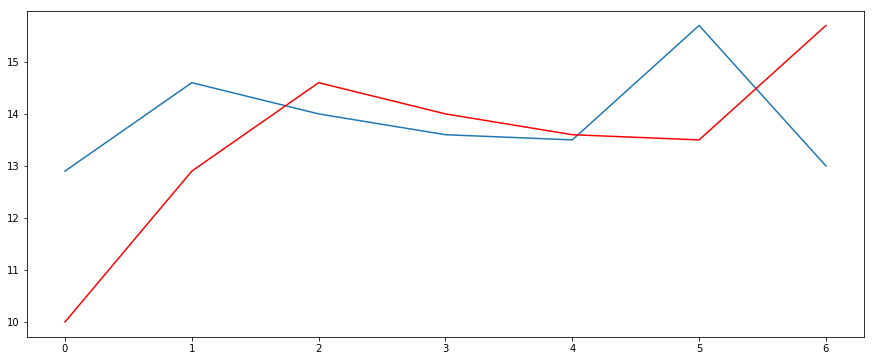

In [48]:
# split train / test
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
    
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

Os valores esperados para os próximos 7 dias são plotados em azul, comparados com as previsões do modelo em vermelho.

### Modelo de Auto-regressão

<div style="text-align:justify">
Um modelo de autorregressão é um modelo de regressão linear que utiliza variáveis com atraso como entrada. Poderíamos calcular o modelo de regressão linear manualmente usando a classe LinearRegession em scikit-learn e especificar manualmente as variáveis de entrada de atraso a serem usadas.
<br><br>
Como alternativa, a biblioteca statsmodels fornece um modelo de regressão automática que seleciona automaticamente um valor de retardo apropriado usando testes estatísticos e treina um modelo de regressão linear. É fornecido na classe AR.
<br><br>
Uma vez ajustado, podemos usar o modelo para fazer uma previsão chamando a função predict() para um número de observações no futuro. Isso cria uma previsão de 7 dias.
</div>

Lag: 29
Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test MSE: 1.502


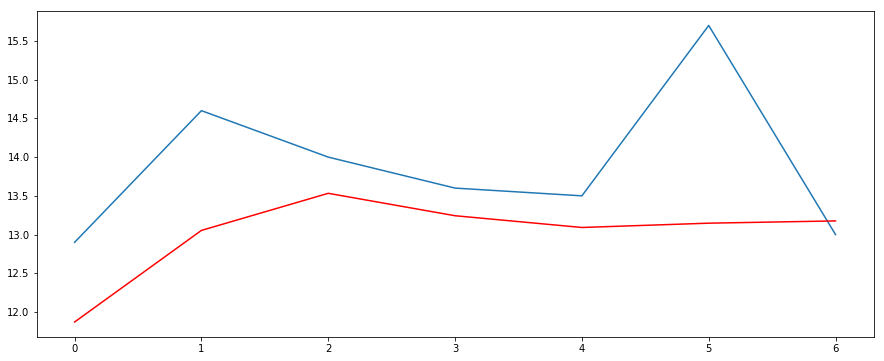

In [49]:
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

<div style="text-align:justify">
Este exemplo imprime o atraso ideal escolhido pelo modelo e os coeficientes de regressão linear ajustado. Podemos ver que um modelo de 29 lag foi escolhido e treinado. Isso é interessante, considerando o quão próximo esse atraso está do número médio de dias em um mês.
<br><br>
A previsão parece muito boa (cerca de 1 grau Celsius a cada dia), com grande desvio no dia 5.
</div>

### Modelo de Autoregressão com Atualização On-line

<div style="text-align:justify">
Em geral, as APIs não facilitam a atualização do modelo à medida que novas observações se tornam disponíveis. Uma maneira seria re-treinar o modelo AR a cada dia à medida que novas observações se tornam disponíveis. Essa pode ser uma abordagem válida, se não for computacionalmente cara.
<br><br>
Uma alternativa seria usar os coeficientes aprendidos e fazer previsões manualmente. Isso requer que o histórico de 29 observações anteriores seja mantido e que os coeficientes sejam recuperados do modelo e usados na equação de regressão para chegar a novas previsões.
<br><br>
Os coeficientes são fornecidos em uma matriz com o termo de interceptação seguido pelos coeficientes para cada variável de atraso, começando em t-1 até t-n. Nós simplesmente precisamos usá-los na ordem correta na história das observações, como segue:
<br><br>
yhat = b0 + b1*X1 + b2*X2 ... bn*Xn
</div>

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test MSE: 1.451


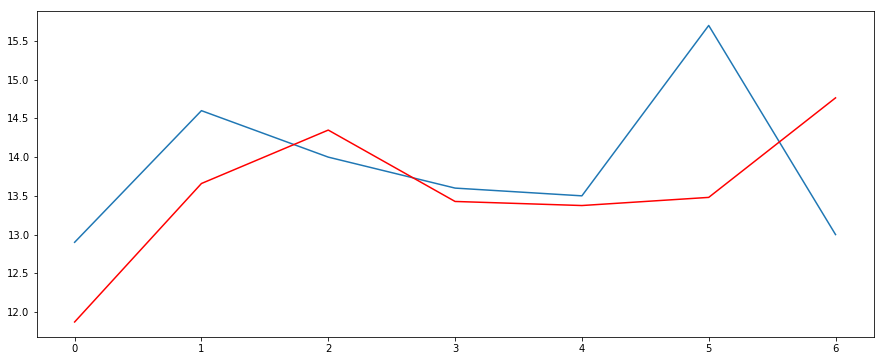

In [50]:
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window, length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### Resumo

- Sobre autocorrelação e autoregressão e como eles podem ser usados para entender a série temporal.
- Como explorar a autocorrelação em uma série temporal usando gráficos e testes estatísticos.
- Como treinar um modelo de autorregressão em Python e usá-lo para fazer previsões de curto prazo e contínuas.